# 说明

这是来自Kaggle的一个[练习项目](https://www.kaggle.com/c/dont-overfit-ii/) 目的如标题所言，怎样做到在较好的预测数据的情况下，不要出现过拟合的问题。

原始说明如下：

## Long ago, in the distant, fragrant mists of time, there was a competition…

It was not just any competition.

It was a competition that challenged mere mortals to model a 20,000x200 matrix of continuous variables using only 250 training samples… without overfitting.

Data scientists ― including Kaggle's very own Will Cukierski ― competed by the hundreds. Legends were made. (Will took 5th place, and eventually ended up working at Kaggle!) People overfit like crazy. It was a Kaggle-y, data science-y madhouse.

So… we're doing it again.

## Don't Overfit II: The Overfittening

This is the next logical step in the evolution of weird competitions. Once again we have 20,000 rows of continuous variables, and a mere handful of training samples. Once again, we challenge you not to overfit. Do your best, model without overfitting, and add, perhaps, to your own legend.

In addition to bragging rights, the winner also gets swag. Enjoy!

## Acknowledgments

We hereby salute the hard work that went into the original competition, created by Phil Brierly. Thank you!

## 数据说明




In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import warnings
import operator
import subprocess
warnings.filterwarnings('ignore')
%precision 2

'%.2f'

In [4]:
train_df = pd.read_csv('./data/train.csv', sep=',', header=0, dtype=float)

In [6]:
train_df.head(3)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0.0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1.0,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2.0,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211


In [209]:
train_df.describe()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.640000,0.023292,-0.026872,0.167404,0.001904,0.001588,-0.007304,0.032052,0.078412,...,0.044652,0.126344,0.018436,-0.012092,-0.065720,-0.106112,0.046472,0.006452,0.009372,-0.128952
std,72.312977,0.480963,0.998354,1.009314,1.021709,1.011751,1.035411,0.955700,1.006657,0.939731,...,1.011416,0.972567,0.954229,0.960630,1.057414,1.038389,0.967661,0.998984,1.008099,0.971219
min,0.000000,0.000000,-2.319000,-2.931000,-2.477000,-2.359000,-2.566000,-2.845000,-2.976000,-3.444000,...,-2.804000,-2.443000,-2.757000,-2.466000,-3.287000,-3.072000,-2.634000,-2.776000,-3.211000,-3.500000
25%,62.250000,0.000000,-0.644750,-0.739750,-0.425250,-0.686500,-0.659000,-0.643750,-0.675000,-0.550750,...,-0.617000,-0.510500,-0.535750,-0.657000,-0.818500,-0.821000,-0.605500,-0.751250,-0.550000,-0.754250
50%,124.500000,1.000000,-0.015500,0.057000,0.184000,-0.016500,-0.023000,0.037500,0.060500,0.183500,...,0.067500,0.091000,0.057500,-0.021000,-0.009000,-0.079500,0.009500,0.005500,-0.009000,-0.132500
75%,186.750000,1.000000,0.677000,0.620750,0.805000,0.720000,0.735000,0.660500,0.783250,0.766250,...,0.797250,0.804250,0.631500,0.650250,0.739500,0.493000,0.683000,0.794250,0.654250,0.503250
max,249.000000,1.000000,2.567000,2.419000,3.392000,2.771000,2.901000,2.793000,2.546000,2.846000,...,2.865000,2.801000,2.736000,2.596000,2.226000,3.131000,3.236000,2.626000,3.530000,2.771000


In [5]:
X = train_df.iloc[:,2:]
Y = train_df.iloc[:,1]

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y ,train_size = .8)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(200, 300)
(50, 300)
(200,)
(50,)


## baseline

In [9]:
def draw_roc(fpr,tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [39]:
def topn(data, n=10):
    d = dict(zip(range(len(data)), data))
    s_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
    return s_d[:n] 

### 选择常见的模型进行测试

In [91]:
models = {
    'lr': LogisticRegression(solver='liblinear', class_weight='balanced', penalty='l1', C=0.1),
    'sgd':SGDClassifier(),
    'adb': AdaBoostClassifier(), 
    'rfc': RandomForestClassifier(n_estimators=1000, max_depth=2), 
    'bag': BaggingClassifier(), 
    'bgc': GradientBoostingClassifier(),
    }

In [116]:
for name, model in models.items():
    model.fit(X_train, Y_train)
    y_hat = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test, y_hat)
    #roc_auc = auc(fpr, tpr)
    score = roc_auc_score(Y_test, y_hat)
    print(f"model({name}):  score = {score} ")
    print("confused matrix:\n", confusion_matrix(Y_test, y_hat))

model(lr):  score = 0.7166666666666666 
confused matrix:
 [[18  2]
 [14 16]]
model(sgd):  score = 0.6083333333333334 
confused matrix:
 [[ 9 11]
 [ 7 23]]
model(adb):  score = 0.6333333333333333 
confused matrix:
 [[10 10]
 [ 7 23]]
model(rfc):  score = 0.5 
confused matrix:
 [[ 0 20]
 [ 0 30]]
model(bag):  score = 0.6166666666666666 
confused matrix:
 [[14  6]
 [14 16]]
model(bgc):  score = 0.6083333333333334 
confused matrix:
 [[ 9 11]
 [ 7 23]]


从说面的结果来看，LR的模型预测结果最好，但是最高的也没有超过0.8，按照LR的模型对测试集进行预测，提交结果到kaggle，结果评分只有0.642.

下面我们尝试对特性值进行选择，然后使用LR进行优化

In [149]:
# 带选择特性的测试
def test_with_idx(f_idx):
    """f_idx list[int] 特性列数组
    """
    model = models['lr']
    scaler = StandardScaler()
    X = scaler.fit_transform(X_train.iloc[:,f_idx])
    T = scaler.fit_transform(X_test.iloc[:,f_idx])
    model.fit(X, Y_train)
    y_hat = model.predict(T)
    fpr, tpr, thresholds = roc_curve(Y_test, y_hat)
    #roc_auc = auc(fpr, tpr)
    score = roc_auc_score(Y_test, y_hat)
    print(f"model(lr):  score = {score} ")
    print("confused matrix:\n", confusion_matrix(Y_test, y_hat))
    return model

## find the top70 features

Confusion matrix, without normalization


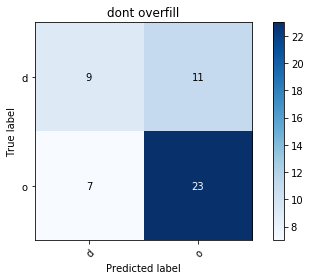

In [119]:
plot_confusion_matrix(Y_test, y_hat, classes='dont_overfill', title="dont overfill");

In [120]:
import eli5
from eli5.sklearn import PermutationImportance

看看特征之间的关系，尝试找到关联最高的70个特征

In [52]:
corrs = train_df.corr().abs().unstack().sort_values(kind='quicksort').reset_index()

In [80]:
f_idx = corrs['level_0'][(corrs.level_0 != corrs.level_1) & (corrs.level_0 != 'target')].tail(70).tolist()

In [121]:
f_idx = list(map(int,f_idx))
model = test_with_idx(f_idx)

model(bgc):  score = 0.7583333333333333 
confused matrix:
 [[19  1]
 [13 17]]


分数有所提高， 我们尝试提交预测结果到kaggle上

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
test_df = pd.read_csv('./data/test.csv.zip')
test_df.drop(['id'], axis=1, inplace=True)

In [125]:
def predict_and_upload(model, f_idx, name=None):
    predicts = model.predict(test_df.iloc[:,f_idx])
    submission['target'] = predicts
    fpath = f'./data/submission_{name}.csv'
    submission.to_csv(fpath, index=False, )
    #upload
    subprocess.Popen(f"kaggle competitions submit -c dont-overfit-ii -f {fpath} -m '{name}'")

In [126]:
predict_and_upload(model, f_idx, name='most 70 features')

这次提交的成绩则提到到 0.72, 很兴奋，但是与高分还有很大的差距，继续挖掘

### Mlextend SequentialFeatureSelector

In [128]:
# fold trains
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=2)


In [168]:
sfs1 = SFS(
    k_features='best',
    forward=True,
    floating=False,
    verbose=1,
    scoring='roc_auc',
    estimator=models['lr'],
    n_jobs=-1,

)

In [169]:
#scaler = StandardScaler()
#X = scaler.fit_transform(X_train)

In [170]:
if __name__ == '__main__':
    sfs1.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x120b0ab70 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
'''
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
_pickle.UnpicklingError: state is not a dictionary
'''

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Library/Frameworks/

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

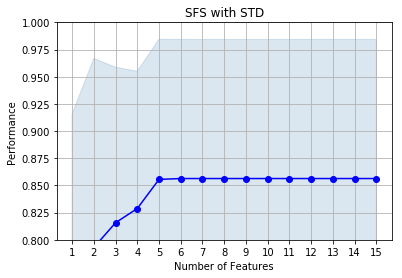

In [151]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim(0.8,1)
plt.title("SFS with STD")
plt.grid()
plt.show()

## optimize

In [146]:
top_features = list(sfs1.k_feature_names_)
print(top_features)

['0', '1', '2', '3', '33', '65', '91', '133', '143', '217']


In [163]:
sfs1.k_features

(10, 15)

In [150]:
model = test_with_idx(list(map(int, top_features)))

model(lr):  score = 0.6666666666666666 
confused matrix:
 [[14  6]
 [11 19]]


In [210]:
## using xgboost
params = {
    'booster': 'gbtree',
    'objective': 'reg:logistic',  # 多分类的问题
    'num_class': 10,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.007,                  # 如同学习率
    'seed': 1000,
    'nthread': 2,                  # cpu 线程数
}
bst = xg

In [69]:
feature_idx = []
cnt = X_train.shape[0]
for i in range(1, cnt+1):
    model2 = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial', )
    model2.fit(X_train.iloc[:,:i], Y_train)
    yhat = model2.predict(X_test.iloc[:,:i])
    #fpr, tpr, thresholds = roc_curve(Y_test, y_hat)
    #roc_auc = auc(fpr, tpr)
    score = roc_auc_score(Y_test, yhat)
    #print(f"baseline score = {score} ")
    if score >= 0.5:
        feature_idx.append(i)

In [79]:
model.densify

<bound method SparseCoefMixin.densify of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>